<a href="https://colab.research.google.com/github/ngric/GAMENet/blob/master/GAMENet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAMENet Reproduction Proposal for CS598 DL4H Spring 2023

**Nile Grice(ngrice2) & Praveen Bhushan (bhushan6)**

**Group ID: 167, Paper ID:173**




# GAMENet Overview

Graph Augmented Memory Networks (GAMENet)
(Shang et al., 2019) aim is to make medication recommendations that do not lead to adverse drugdrug interactions (DDI). To avoid making drug recommendations that lead to DDI, GAMENet adds a graph convolutional
network built from a combination DDI knowledge as well as electronic health record (EHR) data.

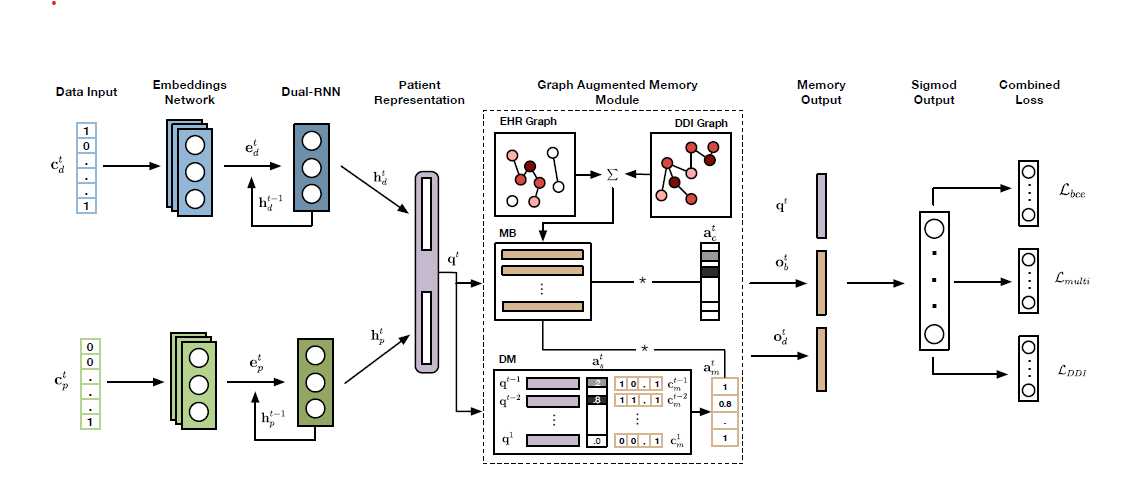

(Shang et al., 2019)

In [ ]:
!pip install dill scikit-learn numpy pandas

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from code.layers import GraphConvolution
import numpy as np
from code.util import llprint, multi_label_metric, ddi_rate_score, get_n_params
from torch.optim import Adam
import dill
from collections import defaultdict
import time
import os
import re

torch.manual_seed(1203)
np.random.seed(1203)

# 1. Data

The original data was sourced from the MIMIC-III (Johnson et al., 2016) and TwoSIDES (Tatonetti et al., 2012) datasets. Data is already preprocessed and following files are provided:

* records_final.pkl: Input data with four dimension (patient_idx, visit_idx, medical modal, medical id). 'medical model' is made up of diagnosis, procedure and drug
* ddi_A_final.pkl & ehr_adj_final.pkl: drug-drug adjacency matrix
* voc_final.pkl: Vocabulary list to transform medical word to corresponding idx

## 1.1. Patient Records

In [ ]:
data_path = './data/records_final.pkl'
data = dill.load(open(data_path, 'rb'))

data is stored as a list of lists representing each patient, each visit, and the diagnoses procedures and prescriptions in each visit.

In [ ]:
data[0] # Patient 0

[[[0, 1, 2, 3, 4, 5, 6, 7],
  [0, 1, 2],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]],
 [[8, 9, 10, 7],
  [3, 4, 1],
  [0, 1, 2, 3, 5, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15]]]

`data[0][0]` - Patient 0, Visit 0

`data[0][0][0]` - Patient 0, Visit 0, Diagnoses (can be converted to codes using diag_voc, see further down)

`data[0][0][1]` - Patient 0, Visit 0, Procedures (can be converted to codes using pro_voc, see further down)

`data[0][0][2]` - Patient 0, Visit 0, Prescriptions (can be converted to codes using med_voc, see further down)

In [ ]:
split_point = int(len(data) * 2 / 3)
data_train = data[:split_point]
eval_len = int(len(data[split_point:]) / 2)
data_test = data[split_point:split_point + eval_len]
data_eval = data[split_point+eval_len:]

## 1.2. Drug Adjacency Graphs

In [ ]:
ehr_adj_path = './data/ehr_adj_final.pkl'
ddi_adj_path = './data/ddi_A_final.pkl'
ehr_adj = dill.load(open(ehr_adj_path, 'rb'))
ddi_adj = dill.load(open(ddi_adj_path, 'rb'))

`ehr_adj` is a an adjacency graph of known medication combinations, taken from EHR data.
`ehr_adj[i][j]` contains a 1 when drugs $i$ and $j$ are known to be prescribed together.

In [ ]:
ehr_adj[10] # All 1's are drugs known to be prescribed together with drug 11

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

`ddi_adj` is a an adjacency graph of known drug-drug interactions.
`ddi_adj[i][j]` contains a 1 when drugs $i$ and $j$ are known to interact.

In [ ]:
ddi_adj[10] # All 1's are drugs known to have adverse interactions with drug 11

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

Both are of shape N drugs x N drugs.
Note, some combinations exist in both adjaceny graphs, as illustrated above

## 1.3. Vocab Mappings

In [ ]:
voc_path = './data/voc_final.pkl'
voc = dill.load(open(voc_path, 'rb'))
diag_voc, pro_voc, med_voc = voc['diag_voc'], voc['pro_voc'], voc['med_voc']

diag_voc, pro_voc, med_voc all contain methods to convert from index numbers to code, and vice versa. For example, drug index 10, from above, is the ATC code 'M01A'

In [ ]:
print([diag_voc.idx2word[i] for i in data[0][0][0]])
print([pro_voc.idx2word[i] for i in data[0][0][1]])
print(med_voc.idx2word[10])

['4239', '5119', '78551', '4589', '311', '7220', '71946', '2724']
['3731', '8872', '3893']
M01A


In [ ]:
print(diag_voc.word2idx['51884'])
print(pro_voc.word2idx['3761'])
print(med_voc.word2idx['M01A'])

120
6
10


## 1.4. Data Statistics
Stats on a per-patient level (repeat diagnoses/procedures/prescriptions only counted once per patient)

In [ ]:
stats = {
    'n_patients': 0,
    'n_medications': 0,
    'n_visits': 0,
    'avg_visits': 0,
    'max_visits': 0,
    'n_diagnoses': 0,
    'avg_diagnoses': 0,
    'max_diagnoses': 0,
    'n_procedures': 0,
    'avg_procedures': 0,
    'max_procedures': 0,
    'n_prescriptions': 0,
    'avg_prescriptions': 0,
    'max_prescriptions': 0,
}

stats['n_patients'] = len(data)
stats['n_medications'] = len(med_voc.word2idx)

for patient in data:
    patient_visits = len(patient)
    if patient_visits > stats['max_visits']:
        stats['max_visits'] = patient_visits
        
    patient_diagnoses = set()
    patient_procedures = set()
    patient_prescriptions = set()
    
    for visit in patient:
        patient_diagnoses.update(visit[0])
        patient_procedures.update(visit[1])
        patient_prescriptions.update(visit[2])
        stats['n_visits'] += 1
        
    
    if len(patient_diagnoses) > stats['max_diagnoses']:
        stats['max_diagnoses'] = len(patient_diagnoses)
    if len(patient_procedures) > stats['max_procedures']:
        stats['max_procedures'] = len(patient_procedures)
    if len(patient_prescriptions) > stats['max_prescriptions']:
        stats['max_prescriptions'] = len(patient_prescriptions)
            
    stats['n_diagnoses'] += len(patient_diagnoses)
    stats['n_procedures'] += len(patient_procedures)
    stats['n_prescriptions'] += len(patient_prescriptions)
            
            
stats['avg_visits'] = stats['n_visits']/stats['n_patients']
stats['avg_diagnoses'] = stats['n_diagnoses']/stats['n_visits']
stats['avg_procedures'] = stats['n_procedures']/stats['n_visits']
stats['avg_prescriptions'] = stats['n_prescriptions']/stats['n_visits']
        
for _, (key, value) in enumerate(stats.items()):
    print(f'{key+":":<20}{value}')

n_patients:         6350
n_medications:      145
n_visits:           15016
avg_visits:         2.3647244094488187
max_visits:         29
n_diagnoses:        157889
avg_diagnoses:      10.514717634523175
max_diagnoses:      128
n_procedures:       57730
avg_procedures:     3.8445657964837507
max_procedures:     50
n_prescriptions:    132204
avg_prescriptions:  8.80420884389984
max_prescriptions:  55


# 2. GAMENet

## 2.1. Overview

GAMENet uses both longitudinal patient EHR data and drug knowledge base on DDIs as inputs.

The model can be broken into the following components: 
1. Dual-RNN Patient Representation
2. Graph Augmented Memory Module
3. Memory Output
4. Combined Loss

## 2.2. Patient Representrtion

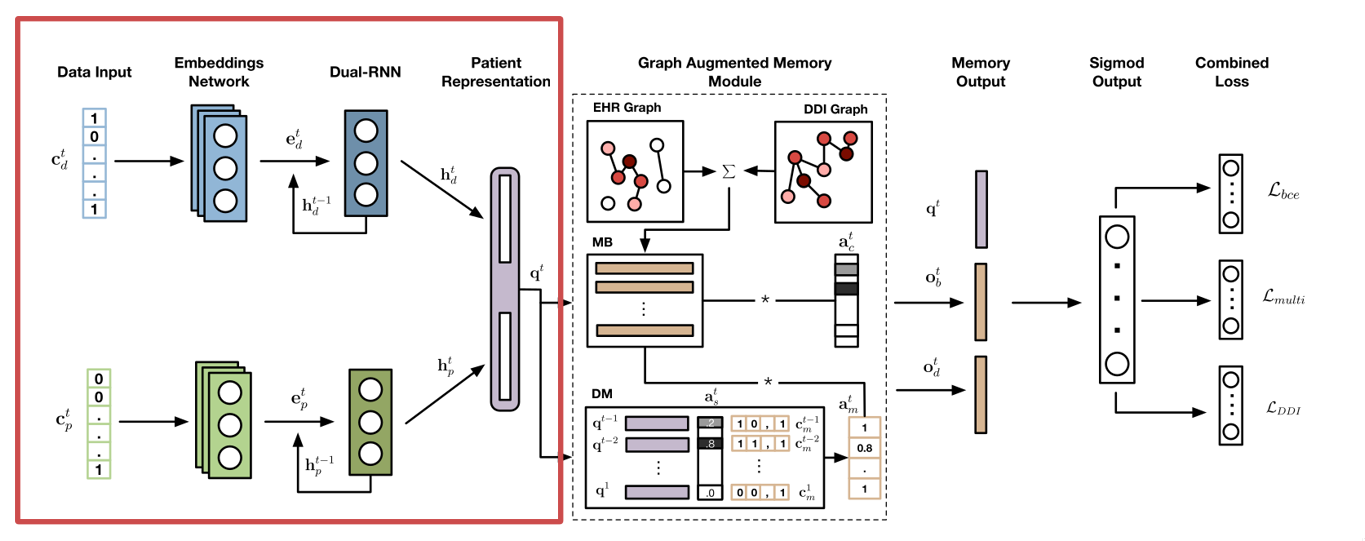

The first part of the GAMENet architecture is the generation of patient representations/queries.

This is accomplished by taking, at each visit $t$, multi-hot vectors of diagnoses ($c_d^t$) and procedures ($c_p^t$) and getting embeddings for each of them. 

$$e_*^t = \bf{W}_{*,e}c_*^t$$

These two sets of embeddings are then each passed through their own RNNs, to account for potentially missing modalities within a visit, to receive $h_d^t$ and $h_p^t$.

$$h_d^t = RNN_d(e_d^1,e_d^2,...,e_d^t)$$
$$h_p^t = RNN_p(e_p^1,e_p^2,...,e_p^t)$$

$h_d^t$ and $h_p^t$ are then concatenated together to get the final patient representation, $q$

$$q^t = f([h_d^t,h_p^t])$$

In [ ]:
class PatientRepresentation(nn.Module):
    def __init__(self, vocab_size, emb_dim=64, device=torch.device('cpu:0')):
        super(PatientRepresentation, self).__init__()
        self.device = device
        
        self.condition_embeddings = nn.Embedding(vocab_size[0], emb_dim)
        self.procedure_embeddings = nn.Embedding(vocab_size[1], emb_dim)
        self.dropout = nn.Dropout(p=0.4)
        
        self.condition_encoder = nn.GRU(emb_dim, emb_dim*2, batch_first=True)
        self.procedure_encoder = nn.GRU(emb_dim, emb_dim*2, batch_first=True)
        
        self.query = nn.Sequential(
            nn.ReLU(),
            nn.Linear(emb_dim * 4, emb_dim),
        )
        
        self.init_weights()

    def init_weights(self):
        """Initialize weights."""
        initrange = 0.1
        self.condition_embeddings.weight.data.uniform_(-initrange, initrange)
        self.procedure_embeddings.weight.data.uniform_(-initrange, initrange)
            
    def forward(self, input):
        # input (adm, 3, codes)

        # generate medical embeddings and queries
        condition_seq = []
        procedure_seq = []
        
        def mean_embedding(embedding):
            return embedding.mean(dim=1).unsqueeze(dim=0)  # (1,1,dim)
        
        for admission in input:
            condition = torch.LongTensor(admission[0]).unsqueeze(dim=0).to(self.device)
            condition = self.condition_embeddings(condition)
            condition = self.dropout(condition)
            condition = mean_embedding(condition)
            
            procedure = torch.LongTensor(admission[1]).unsqueeze(dim=0).to(self.device)
            procedure = self.procedure_embeddings(procedure)
            procedure = self.dropout(procedure)
            procedure = mean_embedding(procedure)
            
            condition_seq.append(condition)
            procedure_seq.append(procedure)
            
        condition_seq = torch.cat(condition_seq, dim=1) #(1,seq,dim)
        procedure_seq = torch.cat(procedure_seq, dim=1) #(1,seq,dim)

        condition_encoding, _ = self.condition_encoder(condition_seq)
        procedure_encoding, _ = self.procedure_encoder(procedure_seq)
        encodings = [condition_encoding, procedure_encoding]
        
        patient_representations = torch.cat(encodings, dim=-1).squeeze(dim=0) # (seq, dim*4)
        queries = self.query(patient_representations) # (seq, dim)
        return queries

## 2.3. Graph Augmented Memory Module

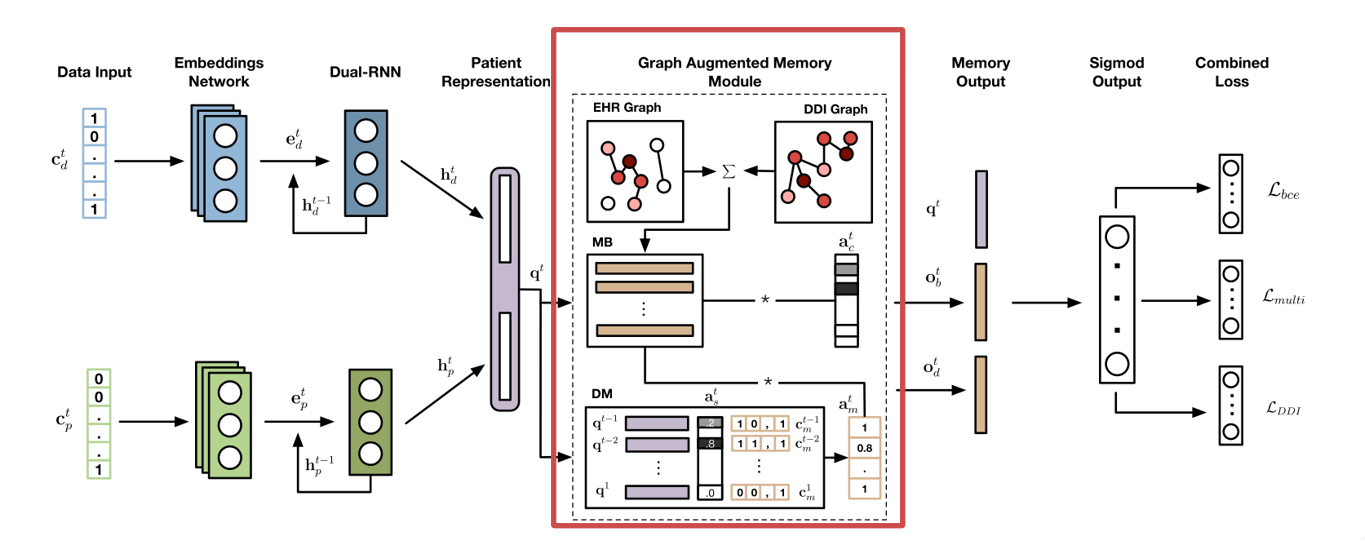

The next component of GAMENet, the Graph Augmented Memory Module, is itself made of two parts:
- Memory Bank (MB) - Weighted sum of EHR and DDI Graph Concolutional Networks:

$$Z_1 = \tilde{A}_e\tanh(\tilde{A}_e W_{e1})W_1$$
$$Z_2 = \tilde{A}_e\tanh(\tilde{A}_e W_{e2})W_1$$

- Dynamic Memory (DM): Memory of past patient visits and medication recommendations

$$M_d^t = \{q^{t'} : c_m^{t'}\}_1^{t-1}$$

### 2.3.1. GCN

In [ ]:
class GCN(nn.Module):
    def __init__(self, voc_size, emb_dim, adj, device=torch.device('cpu:0')):
        super(GCN, self).__init__()
        self.voc_size = voc_size
        self.emb_dim = emb_dim
        self.device = device

        adj = self.normalize(adj + np.eye(adj.shape[0]))

        self.adj = torch.FloatTensor(adj).to(device)
        self.x = torch.eye(voc_size).to(device)

        self.gcn1 = GraphConvolution(voc_size, emb_dim)
        self.dropout = nn.Dropout(p=0.3)
        self.gcn2 = GraphConvolution(emb_dim, emb_dim)

    def forward(self):
        node_embedding = self.gcn1(self.x, self.adj)
        node_embedding = F.relu(node_embedding)
        node_embedding = self.dropout(node_embedding)
        node_embedding = self.gcn2(node_embedding, self.adj)
        return node_embedding

    def normalize(self, mx):
        """Row-normalize sparse matrix"""
        rowsum = np.array(mx.sum(1))
        r_inv = np.power(rowsum, -1).flatten()
        r_inv[np.isinf(r_inv)] = 0.
        r_mat_inv = np.diagflat(r_inv)
        mx = r_mat_inv.dot(mx)
        return mx

## 2.4. GAMENet Model

Inspired by (Weston, Chopra, and Bordes 2015), the Graph Augmented Memory Module is composed of the following:

- **I**: Input memory representation. The conversion of input to query, done above.

$$q^t = f([h_d^t,h_p^t])$$

- **G**: Generalization. Generate and update the DM and MB

$$M_b = Z_1 + \beta Z_2$$
$$M_d^t = \{q^{t'} : c_m^{t'}\}_1^{t-1}$$

- **O**: Output memory representation. Produces outputs $o_b^t$ and $o_d^t$ based upon current memory state.

$$o_b^t = M_b^\mathsf{T}\text{Softmax}(M_b q^t)$$
$$o_d^t = M_b^\mathsf{T} (M_{d,v}^t) \text{Softmax}(M_{d,k}^t q^t)$$

- **R**: Response. Sigmoid of query and outputs. 

$$\hat{y}_t = \sigma([q^t,o_b^t,o_d^t])$$

In [ ]:
class GAMENet(nn.Module):
    def __init__(self, vocab_size, ehr_adj, ddi_adj, emb_dim, device, ddi_in_memory, use_dm):
        super(GAMENet, self).__init__()
        self.vocab_size = vocab_size
        self.device = device
        
        self.patient_rep = PatientRepresentation(vocab_size, emb_dim, device)
        
        self.tensor_ddi_adj = torch.FloatTensor(ddi_adj).to(device)
        self.ddi_in_memory = ddi_in_memory
        self.use_dm = use_dm

        self.ehr_gcn = GCN(voc_size=vocab_size[2], emb_dim=emb_dim, adj=ehr_adj, device=device)
        self.ddi_gcn = GCN(voc_size=vocab_size[2], emb_dim=emb_dim, adj=ddi_adj, device=device)
        self.inter = nn.Parameter(torch.FloatTensor(1))

        in_dims = 3 if use_dm else 2
        self.output = nn.Sequential(
            nn.ReLU(),
            nn.Linear(emb_dim * in_dims, emb_dim * 2),
            nn.ReLU(),
            nn.Linear(emb_dim * 2, vocab_size[2])
        )

        self.init_weights()

    def init_weights(self):
        """Initialize weights."""
        initrange = 0.1
        self.inter.data.uniform_(-initrange, initrange)

    def forward(self, input):
        queries = self.patient_rep(input) # (seq, dim)

        # graph memory module
        '''I:generate current input'''
        query = queries[-1:] # (1,dim)

        '''G:generate graph memory bank and insert history information'''
        if self.ddi_in_memory:
            drug_memory = self.ehr_gcn() - self.ddi_gcn() * self.inter  # (size, dim)
        else:
            drug_memory = self.ehr_gcn()

        if len(input) > 1:
            history_keys = queries[:(queries.size(0)-1)] # (seq-1, dim)

            history_values = np.zeros((len(input)-1, self.vocab_size[2]))
            for idx, adm in enumerate(input):
                if idx == len(input)-1:
                    break
                history_values[idx, adm[2]] = 1
            history_values = torch.FloatTensor(history_values).to(self.device) # (seq-1, size)

        '''O:read from global memory bank and dynamic memory bank'''
        key_weights1 = F.softmax(torch.mm(query, drug_memory.t()), dim=-1)  # (1, size)
        fact1 = torch.mm(key_weights1, drug_memory)  # (1, dim)

        if len(input) > 1 and self.use_dm:
            visit_weight = F.softmax(torch.mm(query, history_keys.t())) # (1, seq-1)
            weighted_values = visit_weight.mm(history_values) # (1, size)
            fact2 = torch.mm(weighted_values, drug_memory) # (1, dim)
        elif self.use_dm:
            fact2 = fact1
            
        '''R:convert O and predict'''
        if self.use_dm:
            output = self.output(torch.cat([query, fact1, fact2], dim=-1)) # (1, dim)
        else:
            output = self.output(torch.cat([query, fact1], dim=-1)) # (1, dim)

        if self.training:
            neg_pred_prob = F.sigmoid(output)
            neg_pred_prob = neg_pred_prob.t() * neg_pred_prob  # (voc_size, voc_size)
            loss_ddi = neg_pred_prob.mul(self.tensor_ddi_adj).mean()

            return output, loss_ddi
        else:
            return output

## 2.5. Combined Loss

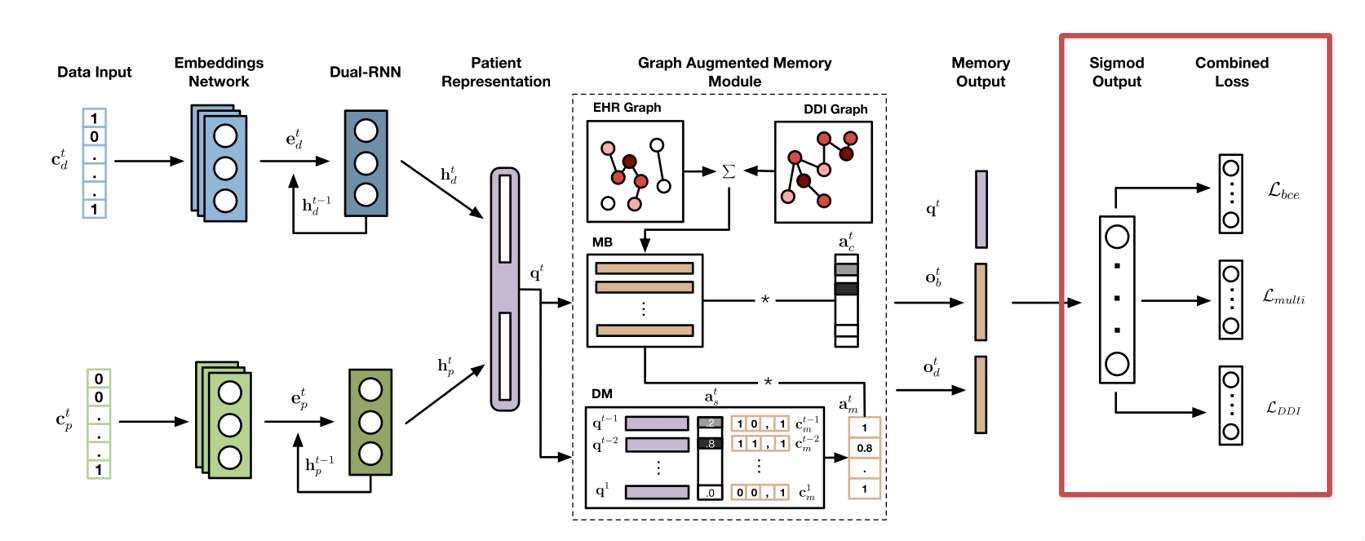

The GAMENet authors combined multiple loss functions together to balance safety and accuracy.

* Accuracy: The authors combine binary cross entropy loss and multi-label margin loss

$$\mathcal{L}_p = \pi[0]\mathcal{L}_{bce}+\pi[1]\mathcal{L}_{multi}$$

* Safety: The authors used DDI loss, which is large when there is a large pair-wise DDI probability

$$\mathcal{L}_{DDI} = \sum_t^T\sum_{i,j}(A_d\odot(\hat{y}_t^\mathsf{T}\hat{y}_t))[i,j]$$

They then combine the two, using the following function:

$$
\mathcal{L} =
    \begin{cases}
        \mathcal{L}_p & \text{if } s' \le s \\
        \mathcal{L}_{DDI}, \text{with prob. } p = \exp(-\frac{s' - s}{Temp}) & \text{if } s' \gt s \\
        \mathcal{L}_p, \text{with prob. } p = 1 - \exp(-\frac{s' - s}{Temp}) & \text{if } s' \gt s
    \end{cases}
$$

where $s$ is the target DDI rate, and $s'$ is the current DDI rate

In [ ]:
def compute_combined_loss(predictions, loss_ddi, loss_bce_target, loss_multi_target, config):
    used_ddi_loss = False
    loss_bce = F.binary_cross_entropy_with_logits(
        predictions,
        torch.FloatTensor(loss_bce_target).to(config['device']))
    loss_multi = F.multilabel_margin_loss(
        F.sigmoid(predictions),
        torch.LongTensor(loss_multi_target).to(config['device']))
    
    if config['use_ddi']:
        predictions = F.sigmoid(predictions).detach().cpu().numpy()[0]
        predictions[predictions >= 0.5] = 1
        y_label = np.where(predictions == 1)[0]
        
        current_ddi_rate = ddi_rate_score([[y_label]], path='./data/ddi_A_final.pkl')
        
        p = np.exp((config['target_ddi'] - current_ddi_rate)/config['temp'])
        p = np.random.rand() >= p
        
        if current_ddi_rate <= config['target_ddi'] or p:
            loss = config['pi'][0] * loss_bce + config['pi'][1] * loss_multi
        else:
            loss = loss_ddi
            used_ddi_loss = True
                
    else: # Don't use DDI graph
        loss = config['pi'][0] * loss_bce + config['pi'][1] * loss_multi
    
    return loss, used_ddi_loss

# 3. Training and Evaluation

## 3.1. Evaluation

In [ ]:
def eval(model, data_eval, config, epoch):
    # evaluate
    print('')
    model.eval()
    smm_record = []
    ja, prauc, avg_p, avg_r, avg_f1 = [[] for _ in range(5)]
    case_study = defaultdict(dict)
    med_cnt = 0
    visit_cnt = 0
    for step, input in enumerate(data_eval):
        y_gt = []
        y_pred = []
        y_pred_prob = []
        y_pred_label = []
        for adm_idx, adm in enumerate(input):

            target_output1 = model(input[:adm_idx+1])

            y_gt_tmp = np.zeros(config['vocab_size'][2])
            y_gt_tmp[adm[2]] = 1
            y_gt.append(y_gt_tmp)

            target_output1 = F.sigmoid(target_output1).detach().cpu().numpy()[0]
            y_pred_prob.append(target_output1)
            y_pred_tmp = target_output1.copy()
            y_pred_tmp[y_pred_tmp>=0.5] = 1
            y_pred_tmp[y_pred_tmp<0.5] = 0
            y_pred.append(y_pred_tmp)
            y_pred_label_tmp = np.where(y_pred_tmp == 1)[0]
            y_pred_label.append(sorted(y_pred_label_tmp))
            visit_cnt += 1
            med_cnt += len(y_pred_label_tmp)


        smm_record.append(y_pred_label)
        adm_ja, adm_prauc, adm_avg_p, adm_avg_r, adm_avg_f1 = multi_label_metric(np.array(y_gt), np.array(y_pred), np.array(y_pred_prob))
        case_study[adm_ja] = {'ja': adm_ja, 'patient': input, 'y_label': y_pred_label}

        ja.append(adm_ja)
        prauc.append(adm_prauc)
        avg_p.append(adm_avg_p)
        avg_r.append(adm_avg_r)
        avg_f1.append(adm_avg_f1)
        llprint('\rEval--Epoch: %d, Step: %d/%d' % (epoch, step, len(data_eval)))

    # ddi rate
    ddi_rate = ddi_rate_score(smm_record,path='./data/ddi_A_final.pkl')

    llprint('\tDDI Rate: %.4f, Jaccard: %.4f,  PRAUC: %.4f, AVG_PRC: %.4f, AVG_RECALL: %.4f, AVG_F1: %.4f\n' % (
        ddi_rate, np.mean(ja), np.mean(prauc), np.mean(avg_p), np.mean(avg_r), np.mean(avg_f1)
    ))
    dill.dump(obj=smm_record, file=open('./data/gamenet_records.pkl', 'wb'))
    dill.dump(case_study, open(os.path.join('saved', config['model_name'], 'case_study.pkl'), 'wb'))

    # print('avg med', med_cnt / visit_cnt)

    return ddi_rate, np.mean(ja), np.mean(prauc), np.mean(avg_p), np.mean(avg_r), np.mean(avg_f1)

#eval(model, data_test, voc_size, 0)

In [ ]:
def load_and_eval(model, config, epoch, data_test, results):
    directory = f'./saved/{config["model_name"]}'
    regex = fr'^Epoch_{epoch}_'
    filepath = ""

    pattern = re.compile(regex)
    for root, dirs, files in os.walk(directory):
        for file in files:
            if pattern.match(file):
                filepath = os.path.join(root, file)
    
    if filepath != "":
        print(f'loading {filepath}')
        model.load_state_dict(torch.load(filepath))
        result = eval(model, data_test, config, epoch)
        results.append({
            'config': config,
            'best_epoch': best_epoch,
            'ddi': result[0],
            'ja': result[1],
            'prauc': result[2],
            'avg_p': result[3],
            'avg_r': result[4],
            'avg_f1': result[5]
        })
    else:
        print('Unable to find that model')

## 3.2. Train

In [ ]:
def train(model, data_train, config):
  if not os.path.exists(os.path.join("saved", config['model_name'])):
    os.makedirs(os.path.join("saved", config['model_name']))

  best_epoch = 0
  best_ja = 0
  start_time = time.time()

  for epoch in range(config['epochs']):
    loss_record = []
    epoch_time = time.time()
    model.train()
    prediction_loss_cnt = 0
    ddi_loss_cnt = 0

    for step, input in enumerate(data_train):
      for idx, adm in enumerate(input):
        seq_input = input[:idx+1]
        loss_bce_target = np.zeros((1, config['vocab_size'][2]))
        loss_bce_target[:, adm[2]] = 1
        loss_multi_target = np.full((1, config['vocab_size'][2]), -1)
        
        for idx, item in enumerate(adm[2]):
          loss_multi_target[0][idx] = item

        predictions, loss_ddi = model(seq_input)
        loss, inc_ddi_loss_cnt = compute_combined_loss(predictions, loss_ddi, loss_bce_target, loss_multi_target, config)

        if inc_ddi_loss_cnt:
            ddi_loss_cnt += 1
        else:
            prediction_loss_cnt += 1

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        loss_record.append(loss.item())

      llprint('\rTrain--Epoch: %d, Step: %d/%d, L_p cnt: %d, L_neg cnt: %d' % 
              (epoch, step, len(data_train), prediction_loss_cnt, ddi_loss_cnt))
      
    # annealing
    config['temp'] *= config['decay_weight']

    ddi_rate, ja, prauc, avg_p, avg_r, avg_f1 = eval(model, data_eval, config, epoch)

    end_time = time.time()
    elapsed_time = (end_time - epoch_time) / 60
    llprint('\tEpoch: %d, Loss: %.4f, One Epoch Time: %.2fm, Appro Left Time: %.2fh\n' % 
            (epoch, np.mean(loss_record), elapsed_time, elapsed_time * ( config['epochs'] - epoch - 1)/60))

    torch.save(
        model.state_dict(),
        open(os.path.join(
            'saved',
            config['model_name'],
            'Epoch_%d_JA_%.4f_DDI_%.4f.model' % (epoch, ja, ddi_rate)),
            'wb'))
    
    print('')
    if epoch != 0 and best_ja < ja:
      best_epoch = epoch
      best_ja = ja

  total_time = (time.time() - start_time) / 60 / 60 
  print('best_epoch:', best_epoch)
  print(f'total time: {total_time}h')
  return best_epoch

# Run Experiments

In [ ]:
results = []

## Hyperparameters from paper authors' code

In [ ]:
config = {
    'model_name': 'GAMENet',
    'device': torch.device('cpu:0'),
    'epochs': 40,
    'use_ddi': True,
    'use_dm': True,
    'vocab_size': (len(diag_voc.idx2word), len(pro_voc.idx2word), len(med_voc.idx2word)),
    'embedding_dim': 64,
    'temp': 0.5,
    'decay_weight': 0.85,
    'target_ddi': 0.05,
    'pi': [.9, .01],
    'learning_rate': 0.0002
}

model = GAMENet(
    config['vocab_size'],
    ehr_adj,
    ddi_adj,
    config['embedding_dim'],
    config['device'],
    config['use_ddi'],
    config['use_dm']
)
model.to(device=config['device'])

print('GAMENet Model parameters:', get_n_params(model))
optimizer = Adam(list(model.parameters()), lr=config['learning_rate'])

best_epoch = train(model, data_train, config)

GAMENet Model parameters: 452434
Train--Epoch: 0, Step: 4232/4233, L_p cnt: 4813, L_neg cnt: 5662
Eval--Epoch: 0, Step: 1058/1059	DDI Rate: 0.0904, Jaccard: 0.3580,  PRAUC: 0.6221, AVG_PRC: 0.6266, AVG_RECALL: 0.4709, AVG_F1: 0.5190
	Epoch: 0, Loss: 0.1204, One Epoch Time: 1.87m, Appro Left Time: 1.22h

Train--Epoch: 1, Step: 4232/4233, L_p cnt: 6047, L_neg cnt: 4428
Eval--Epoch: 1, Step: 1058/1059	DDI Rate: 0.0891, Jaccard: 0.3599,  PRAUC: 0.6243, AVG_PRC: 0.6344, AVG_RECALL: 0.4688, AVG_F1: 0.5210
	Epoch: 1, Loss: 0.1434, One Epoch Time: 1.94m, Appro Left Time: 1.23h

Train--Epoch: 2, Step: 4232/4233, L_p cnt: 5524, L_neg cnt: 4951
Eval--Epoch: 2, Step: 1058/1059	DDI Rate: 0.0398, Jaccard: 0.3726,  PRAUC: 0.6380, AVG_PRC: 0.6538, AVG_RECALL: 0.4763, AVG_F1: 0.5341
	Epoch: 2, Loss: 0.1284, One Epoch Time: 1.93m, Appro Left Time: 1.19h

Train--Epoch: 3, Step: 4232/4233, L_p cnt: 6795, L_neg cnt: 3680
Eval--Epoch: 3, Step: 1058/1059	DDI Rate: 0.0572, Jaccard: 0.3928,  PRAUC: 0.6524, AVG

In [ ]:
load_and_eval(model, config, best_epoch, data_test, results)

loading ./saved/GAMENet/Epoch_39_JA_0.4557_DDI_0.0872.model

Eval--Epoch: 39, Step: 1057/1058	DDI Rate: 0.0852, Jaccard: 0.4501,  PRAUC: 0.6885, AVG_PRC: 0.6231, AVG_RECALL: 0.6277, AVG_F1: 0.6072


## Tweaked hyperparameters

In [ ]:
config = {
    'model_name': 'GAMENet_.95_decay_weight',
    'device': torch.device('cpu:0'),
    'epochs': 40,
    'use_ddi': True,
    'use_dm': True,
    'vocab_size': (len(diag_voc.idx2word), len(pro_voc.idx2word), len(med_voc.idx2word)),
    'embedding_dim': 64,
    'temp': 0.5,
    'decay_weight': 0.95,
    'target_ddi': 0.05,
    'pi': [.9, .01],
    'learning_rate': 0.0002
}

model = GAMENet(
    config['vocab_size'],
    ehr_adj,
    ddi_adj,
    config['embedding_dim'],
    config['device'],
    config['use_ddi'],
    config['use_dm']
)
model.to(device=config['device'])

print('GAMENet Model parameters:', get_n_params(model))
optimizer = Adam(list(model.parameters()), lr=config['learning_rate'])

best_epoch = train(model, data_train, config)

GAMENet Model parameters: 452434
Train--Epoch: 0, Step: 4232/4233, L_p cnt: 5206, L_neg cnt: 5269
Eval--Epoch: 0, Step: 1058/1059	DDI Rate: 0.0909, Jaccard: 0.3627,  PRAUC: 0.6195, AVG_PRC: 0.6152, AVG_RECALL: 0.4860, AVG_F1: 0.5242
	Epoch: 0, Loss: 0.1302, One Epoch Time: 2.03m, Appro Left Time: 1.32h

Train--Epoch: 1, Step: 4232/4233, L_p cnt: 6350, L_neg cnt: 4125
Eval--Epoch: 1, Step: 1058/1059	DDI Rate: 0.0293, Jaccard: 0.3598,  PRAUC: 0.6314, AVG_PRC: 0.6478, AVG_RECALL: 0.4638, AVG_F1: 0.5207
	Epoch: 1, Loss: 0.1511, One Epoch Time: 2.04m, Appro Left Time: 1.29h

Train--Epoch: 2, Step: 4232/4233, L_p cnt: 6429, L_neg cnt: 4046
Eval--Epoch: 2, Step: 1058/1059	DDI Rate: 0.0575, Jaccard: 0.3780,  PRAUC: 0.6415, AVG_PRC: 0.6437, AVG_RECALL: 0.4921, AVG_F1: 0.5392
	Epoch: 2, Loss: 0.1525, One Epoch Time: 1.97m, Appro Left Time: 1.21h

Train--Epoch: 3, Step: 4232/4233, L_p cnt: 5942, L_neg cnt: 4533
Eval--Epoch: 3, Step: 1058/1059	DDI Rate: 0.0629, Jaccard: 0.3951,  PRAUC: 0.6490, AVG

In [ ]:
load_and_eval(model, config, best_epoch, data_test, results)

In [ ]:
config = {
    'model_name': 'GAMENet_no_decay',
    'device': torch.device('cpu:0'),
    'epochs': 40,
    'use_ddi': True,
    'use_dm': True,
    'vocab_size': (len(diag_voc.idx2word), len(pro_voc.idx2word), len(med_voc.idx2word)),
    'embedding_dim': 64,
    'temp': 0.5,
    'decay_weight': 1,
    'target_ddi': 0.05,
    'pi': [.9, .01],
    'learning_rate': 0.0002
}

model = GAMENet(
    config['vocab_size'],
    ehr_adj,
    ddi_adj,
    config['embedding_dim'],
    config['device'],
    config['use_ddi'],
    config['use_dm']
)
model.to(device=config['device'])

print('GAMENet Model parameters:', get_n_params(model))
optimizer = Adam(list(model.parameters()), lr=config['learning_rate'])

best_epoch = train(model, data_train, config)

In [ ]:
load_and_eval(model, config, best_epoch, data_test, results)

## Ablations

### Remove DM

In [ ]:
config = {
    'model_name': 'GAMENet_without_DM',
    'device': torch.device('cpu:0'),
    'epochs': 40,
    'use_ddi': True,
    'use_dm': False,
    'vocab_size': (len(diag_voc.idx2word), len(pro_voc.idx2word), len(med_voc.idx2word)),
    'embedding_dim': 64,
    'temp': 0.5,
    'decay_weight': 0.85,
    'target_ddi': 0.05,
    'pi': [.9, .01],
    'learning_rate': 0.0002
}

model = GAMENet(
    config['vocab_size'],
    ehr_adj,
    ddi_adj,
    config['embedding_dim'],
    config['device'],
    config['use_ddi'],
    config['use_dm']
)
model.to(device=config['device'])

print('GAMENet Model parameters:', get_n_params(model))
optimizer = Adam(list(model.parameters()), lr=config['learning_rate'])

best_epoch = train(model, data_train, config)

In [ ]:
load_and_eval(model, config, best_epoch, data_test, results)

### Remove DDI (from paper)

In [ ]:
config = {
    'model_name': 'GAMENet_no_DDI',
    'device': torch.device('cpu:0'),
    'epochs': 40,
    'use_ddi': False,
    'use_dm': True,
    'vocab_size': (len(diag_voc.idx2word), len(pro_voc.idx2word), len(med_voc.idx2word)),
    'embedding_dim': 64,
    'temp': 0.5,
    'decay_weight': 0.85,
    'target_ddi': 0.05,
    'pi': [.9, .01],
    'learning_rate': 0.0002
}

model = GAMENet(
    config['vocab_size'],
    ehr_adj,
    ddi_adj,
    config['embedding_dim'],
    config['device'],
    config['use_ddi'],
    config['use_dm']
)
model.to(device=config['device'])

print('GAMENet Model parameters:', get_n_params(model))
optimizer = Adam(list(model.parameters()), lr=config['learning_rate'])

best_epoch = train(model, data_train, config)

In [ ]:
load_and_eval(model, config, best_epoch, data_test, results)

# Results

In [ ]:
def print_results_table(results):
  headers = ['model_name'] + list(results[0].keys())[1:]
  row_format = "{:<12}" * len(headers)
  
  print(row_format.format(*headers))
  for result in results:
      model_name = result['config']['model_name']
      other_values = list(result.values())[1:]
      print(row_format.format(model_name, *other_values))

In [ ]:
print_results_table(results)

# References

A. Johnson, T. Pollard, and R. Mark. 2016. Mimic-iii clinical database (version 1.4). PhysioNet.

Junyuan Shang, Cao Xiao, Tengfei Ma, Hongyan Li, and Jimeng Sun. 2019. Gamenet: Graph augmented memory networks for recommending medication combination. Proceedings of the AAAI Conference on Artificial Intelligence, 33(01):1126–1133.

N. Tatonetti, P. Ye, R. Daneshjou, and R Altman. 2012. Data-driven prediction of drug effects and interactions. Science Translational Medicine, 4(125)

Weston, J.; Chopra, S.; and Bordes, A. 2015. Memory networks. In International Conference on Learning Representations.

<a href="https://colab.research.google.com/github/ngric/GAMENet/blob/master/GAMENet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAMENet Reproduction Proposal for CS598 DL4H Spring 2023

**Nile Grice(ngrice2) & Praveen Bhushan (bhushan6)**

**Group ID: 167, Paper ID:173**




# GAMENet Overview

Graph Augmented Memory Networks (GAMENet)
(Shang et al., 2019) aim is to make medication recommendations that do not lead to adverse drugdrug interactions (DDI). To avoid making drug recommendations that lead to DDI, GAMENet adds a graph convolutional
network built from a combination DDI knowledge as well as electronic health record (EHR) data.

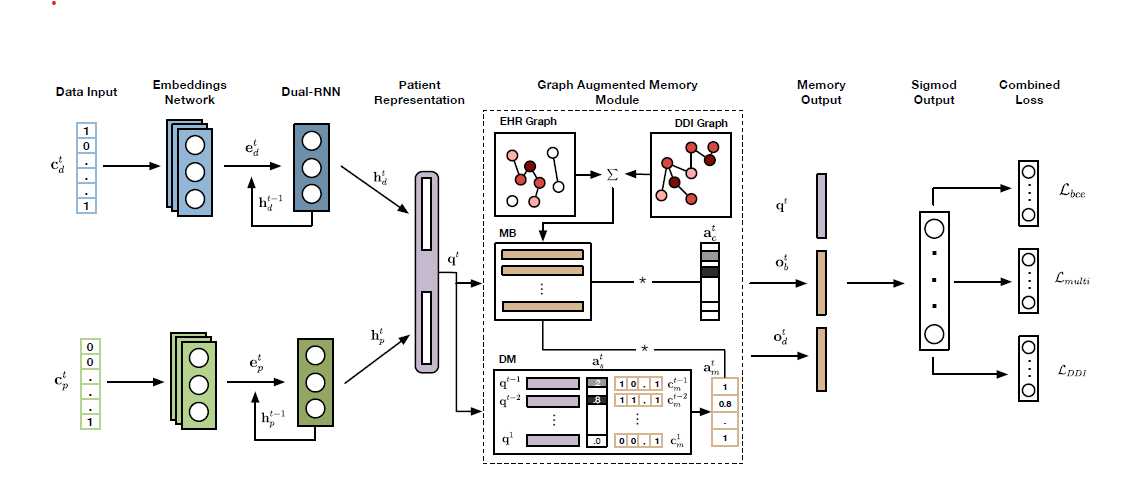

(Shang et al., 2019)

In [ ]:
!pip install dill scikit-learn numpy pandas

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from code.layers import GraphConvolution
import numpy as np
from code.util import llprint, multi_label_metric, ddi_rate_score, get_n_params
from torch.optim import Adam
import dill
from collections import defaultdict
import time
import os
import re

torch.manual_seed(1203)
np.random.seed(1203)

# 1. Data

The original data was sourced from the MIMIC-III (Johnson et al., 2016) and TwoSIDES (Tatonetti et al., 2012) datasets. Data is already preprocessed and following files are provided:

* records_final.pkl: Input data with four dimension (patient_idx, visit_idx, medical modal, medical id). 'medical model' is made up of diagnosis, procedure and drug
* ddi_A_final.pkl & ehr_adj_final.pkl: drug-drug adjacency matrix
* voc_final.pkl: Vocabulary list to transform medical word to corresponding idx

## 1.1. Patient Records

In [ ]:
data_path = './data/records_final.pkl'
data = dill.load(open(data_path, 'rb'))

data is stored as a list of lists representing each patient, each visit, and the diagnoses procedures and prescriptions in each visit.

In [ ]:
data[0] # Patient 0

[[[0, 1, 2, 3, 4, 5, 6, 7],
  [0, 1, 2],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]],
 [[8, 9, 10, 7],
  [3, 4, 1],
  [0, 1, 2, 3, 5, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15]]]

`data[0][0]` - Patient 0, Visit 0

`data[0][0][0]` - Patient 0, Visit 0, Diagnoses (can be converted to codes using diag_voc, see further down)

`data[0][0][1]` - Patient 0, Visit 0, Procedures (can be converted to codes using pro_voc, see further down)

`data[0][0][2]` - Patient 0, Visit 0, Prescriptions (can be converted to codes using med_voc, see further down)

In [ ]:
split_point = int(len(data) * 2 / 3)
data_train = data[:split_point]
eval_len = int(len(data[split_point:]) / 2)
data_test = data[split_point:split_point + eval_len]
data_eval = data[split_point+eval_len:]

## 1.2. Drug Adjacency Graphs

In [ ]:
ehr_adj_path = './data/ehr_adj_final.pkl'
ddi_adj_path = './data/ddi_A_final.pkl'
ehr_adj = dill.load(open(ehr_adj_path, 'rb'))
ddi_adj = dill.load(open(ddi_adj_path, 'rb'))

`ehr_adj` is a an adjacency graph of known medication combinations, taken from EHR data.
`ehr_adj[i][j]` contains a 1 when drugs $i$ and $j$ are known to be prescribed together.

In [ ]:
ehr_adj[10] # All 1's are drugs known to be prescribed together with drug 11

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

`ddi_adj` is a an adjacency graph of known drug-drug interactions.
`ddi_adj[i][j]` contains a 1 when drugs $i$ and $j$ are known to interact.

In [ ]:
ddi_adj[10] # All 1's are drugs known to have adverse interactions with drug 11

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

Both are of shape N drugs x N drugs.
Note, some combinations exist in both adjaceny graphs, as illustrated above

## 1.3. Vocab Mappings

In [ ]:
voc_path = './data/voc_final.pkl'
voc = dill.load(open(voc_path, 'rb'))
diag_voc, pro_voc, med_voc = voc['diag_voc'], voc['pro_voc'], voc['med_voc']

diag_voc, pro_voc, med_voc all contain methods to convert from index numbers to code, and vice versa. For example, drug index 10, from above, is the ATC code 'M01A'

In [ ]:
print([diag_voc.idx2word[i] for i in data[0][0][0]])
print([pro_voc.idx2word[i] for i in data[0][0][1]])
print(med_voc.idx2word[10])

['4239', '5119', '78551', '4589', '311', '7220', '71946', '2724']
['3731', '8872', '3893']
M01A


In [ ]:
print(diag_voc.word2idx['51884'])
print(pro_voc.word2idx['3761'])
print(med_voc.word2idx['M01A'])

120
6
10


## 1.4. Data Statistics
Stats on a per-patient level (repeat diagnoses/procedures/prescriptions only counted once per patient)

In [ ]:
stats = {
    'n_patients': 0,
    'n_medications': 0,
    'n_visits': 0,
    'avg_visits': 0,
    'max_visits': 0,
    'n_diagnoses': 0,
    'avg_diagnoses': 0,
    'max_diagnoses': 0,
    'n_procedures': 0,
    'avg_procedures': 0,
    'max_procedures': 0,
    'n_prescriptions': 0,
    'avg_prescriptions': 0,
    'max_prescriptions': 0,
}

stats['n_patients'] = len(data)
stats['n_medications'] = len(med_voc.word2idx)

for patient in data:
    patient_visits = len(patient)
    if patient_visits > stats['max_visits']:
        stats['max_visits'] = patient_visits
        
    patient_diagnoses = set()
    patient_procedures = set()
    patient_prescriptions = set()
    
    for visit in patient:
        patient_diagnoses.update(visit[0])
        patient_procedures.update(visit[1])
        patient_prescriptions.update(visit[2])
        stats['n_visits'] += 1
        
    
    if len(patient_diagnoses) > stats['max_diagnoses']:
        stats['max_diagnoses'] = len(patient_diagnoses)
    if len(patient_procedures) > stats['max_procedures']:
        stats['max_procedures'] = len(patient_procedures)
    if len(patient_prescriptions) > stats['max_prescriptions']:
        stats['max_prescriptions'] = len(patient_prescriptions)
            
    stats['n_diagnoses'] += len(patient_diagnoses)
    stats['n_procedures'] += len(patient_procedures)
    stats['n_prescriptions'] += len(patient_prescriptions)
            
            
stats['avg_visits'] = stats['n_visits']/stats['n_patients']
stats['avg_diagnoses'] = stats['n_diagnoses']/stats['n_visits']
stats['avg_procedures'] = stats['n_procedures']/stats['n_visits']
stats['avg_prescriptions'] = stats['n_prescriptions']/stats['n_visits']
        
for _, (key, value) in enumerate(stats.items()):
    print(f'{key+":":<20}{value}')

n_patients:         6350
n_medications:      145
n_visits:           15016
avg_visits:         2.3647244094488187
max_visits:         29
n_diagnoses:        157889
avg_diagnoses:      10.514717634523175
max_diagnoses:      128
n_procedures:       57730
avg_procedures:     3.8445657964837507
max_procedures:     50
n_prescriptions:    132204
avg_prescriptions:  8.80420884389984
max_prescriptions:  55


# 2. GAMENet

## 2.1. Overview

GAMENet uses both longitudinal patient EHR data and drug knowledge base on DDIs as inputs.

The model can be broken into the following components: 
1. Dual-RNN Patient Representation
2. Graph Augmented Memory Module
3. Memory Output
4. Combined Loss

## 2.2. Patient Representrtion

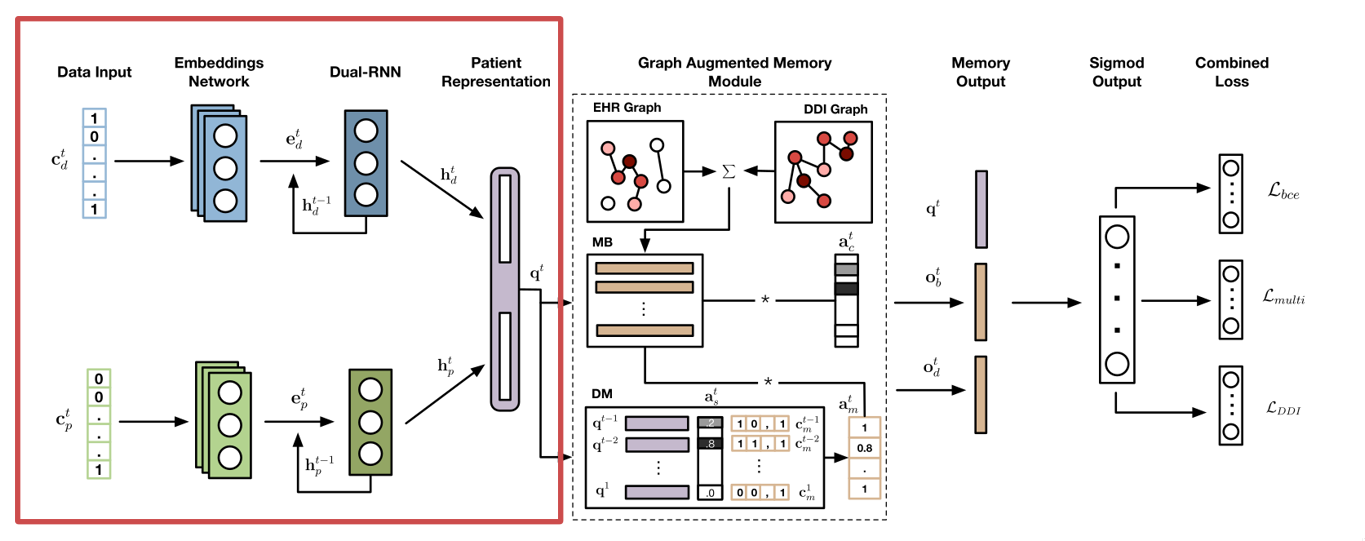

The first part of the GAMENet architecture is the generation of patient representations/queries.

This is accomplished by taking, at each visit $t$, multi-hot vectors of diagnoses ($c_d^t$) and procedures ($c_p^t$) and getting embeddings for each of them. 

$$e_*^t = \bf{W}_{*,e}c_*^t$$

These two sets of embeddings are then each passed through their own RNNs, to account for potentially missing modalities within a visit, to receive $h_d^t$ and $h_p^t$.

$$h_d^t = RNN_d(e_d^1,e_d^2,...,e_d^t)$$
$$h_p^t = RNN_p(e_p^1,e_p^2,...,e_p^t)$$

$h_d^t$ and $h_p^t$ are then concatenated together to get the final patient representation, $q$

$$q^t = f([h_d^t,h_p^t])$$

In [ ]:
class PatientRepresentation(nn.Module):
    def __init__(self, vocab_size, emb_dim=64, device=torch.device('cpu:0')):
        super(PatientRepresentation, self).__init__()
        self.device = device
        
        self.condition_embeddings = nn.Embedding(vocab_size[0], emb_dim)
        self.procedure_embeddings = nn.Embedding(vocab_size[1], emb_dim)
        self.dropout = nn.Dropout(p=0.4)
        
        self.condition_encoder = nn.GRU(emb_dim, emb_dim*2, batch_first=True)
        self.procedure_encoder = nn.GRU(emb_dim, emb_dim*2, batch_first=True)
        
        self.query = nn.Sequential(
            nn.ReLU(),
            nn.Linear(emb_dim * 4, emb_dim),
        )
        
        self.init_weights()

    def init_weights(self):
        """Initialize weights."""
        initrange = 0.1
        self.condition_embeddings.weight.data.uniform_(-initrange, initrange)
        self.procedure_embeddings.weight.data.uniform_(-initrange, initrange)
            
    def forward(self, input):
        # input (adm, 3, codes)

        # generate medical embeddings and queries
        condition_seq = []
        procedure_seq = []
        
        def mean_embedding(embedding):
            return embedding.mean(dim=1).unsqueeze(dim=0)  # (1,1,dim)
        
        for admission in input:
            condition = torch.LongTensor(admission[0]).unsqueeze(dim=0).to(self.device)
            condition = self.condition_embeddings(condition)
            condition = self.dropout(condition)
            condition = mean_embedding(condition)
            
            procedure = torch.LongTensor(admission[1]).unsqueeze(dim=0).to(self.device)
            procedure = self.procedure_embeddings(procedure)
            procedure = self.dropout(procedure)
            procedure = mean_embedding(procedure)
            
            condition_seq.append(condition)
            procedure_seq.append(procedure)
            
        condition_seq = torch.cat(condition_seq, dim=1) #(1,seq,dim)
        procedure_seq = torch.cat(procedure_seq, dim=1) #(1,seq,dim)

        condition_encoding, _ = self.condition_encoder(condition_seq)
        procedure_encoding, _ = self.procedure_encoder(procedure_seq)
        encodings = [condition_encoding, procedure_encoding]
        
        patient_representations = torch.cat(encodings, dim=-1).squeeze(dim=0) # (seq, dim*4)
        queries = self.query(patient_representations) # (seq, dim)
        return queries

## 2.3. Graph Augmented Memory Module

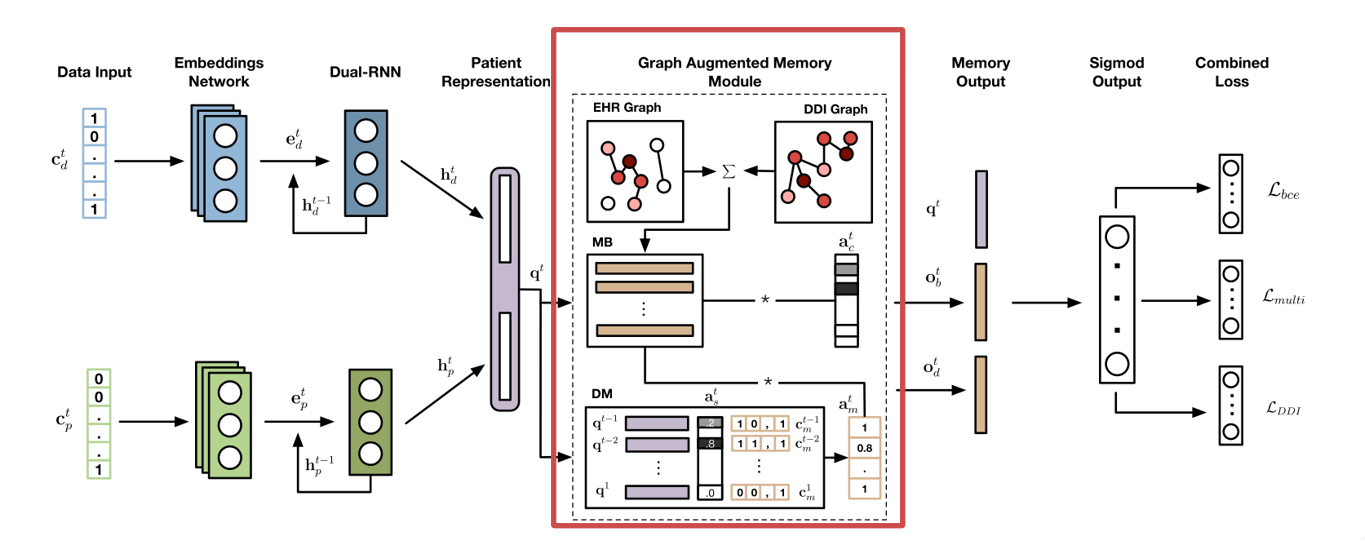

The next component of GAMENet, the Graph Augmented Memory Module, is itself made of two parts:
- Memory Bank (MB) - Weighted sum of EHR and DDI Graph Concolutional Networks:

$$Z_1 = \tilde{A}_e\tanh(\tilde{A}_e W_{e1})W_1$$
$$Z_2 = \tilde{A}_e\tanh(\tilde{A}_e W_{e2})W_1$$

- Dynamic Memory (DM): Memory of past patient visits and medication recommendations

$$M_d^t = \{q^{t'} : c_m^{t'}\}_1^{t-1}$$

### 2.3.1. GCN

In [ ]:
class GCN(nn.Module):
    def __init__(self, voc_size, emb_dim, adj, device=torch.device('cpu:0')):
        super(GCN, self).__init__()
        self.voc_size = voc_size
        self.emb_dim = emb_dim
        self.device = device

        adj = self.normalize(adj + np.eye(adj.shape[0]))

        self.adj = torch.FloatTensor(adj).to(device)
        self.x = torch.eye(voc_size).to(device)

        self.gcn1 = GraphConvolution(voc_size, emb_dim)
        self.dropout = nn.Dropout(p=0.3)
        self.gcn2 = GraphConvolution(emb_dim, emb_dim)

    def forward(self):
        node_embedding = self.gcn1(self.x, self.adj)
        node_embedding = F.relu(node_embedding)
        node_embedding = self.dropout(node_embedding)
        node_embedding = self.gcn2(node_embedding, self.adj)
        return node_embedding

    def normalize(self, mx):
        """Row-normalize sparse matrix"""
        rowsum = np.array(mx.sum(1))
        r_inv = np.power(rowsum, -1).flatten()
        r_inv[np.isinf(r_inv)] = 0.
        r_mat_inv = np.diagflat(r_inv)
        mx = r_mat_inv.dot(mx)
        return mx

## 2.4. GAMENet Model

Inspired by (Weston, Chopra, and Bordes 2015), the Graph Augmented Memory Module is composed of the following:

- **I**: Input memory representation. The conversion of input to query, done above.

$$q^t = f([h_d^t,h_p^t])$$

- **G**: Generalization. Generate and update the DM and MB

$$M_b = Z_1 + \beta Z_2$$
$$M_d^t = \{q^{t'} : c_m^{t'}\}_1^{t-1}$$

- **O**: Output memory representation. Produces outputs $o_b^t$ and $o_d^t$ based upon current memory state.

$$o_b^t = M_b^\mathsf{T}\text{Softmax}(M_b q^t)$$
$$o_d^t = M_b^\mathsf{T} (M_{d,v}^t) \text{Softmax}(M_{d,k}^t q^t)$$

- **R**: Response. Sigmoid of query and outputs. 

$$\hat{y}_t = \sigma([q^t,o_b^t,o_d^t])$$

In [ ]:
class GAMENet(nn.Module):
    def __init__(self, vocab_size, ehr_adj, ddi_adj, emb_dim, device, ddi_in_memory, use_dm):
        super(GAMENet, self).__init__()
        self.vocab_size = vocab_size
        self.device = device
        
        self.patient_rep = PatientRepresentation(vocab_size, emb_dim, device)
        
        self.tensor_ddi_adj = torch.FloatTensor(ddi_adj).to(device)
        self.ddi_in_memory = ddi_in_memory
        self.use_dm = use_dm

        self.ehr_gcn = GCN(voc_size=vocab_size[2], emb_dim=emb_dim, adj=ehr_adj, device=device)
        self.ddi_gcn = GCN(voc_size=vocab_size[2], emb_dim=emb_dim, adj=ddi_adj, device=device)
        self.inter = nn.Parameter(torch.FloatTensor(1))

        in_dims = 3 if use_dm else 2
        self.output = nn.Sequential(
            nn.ReLU(),
            nn.Linear(emb_dim * in_dims, emb_dim * 2),
            nn.ReLU(),
            nn.Linear(emb_dim * 2, vocab_size[2])
        )

        self.init_weights()

    def init_weights(self):
        """Initialize weights."""
        initrange = 0.1
        self.inter.data.uniform_(-initrange, initrange)

    def forward(self, input):
        queries = self.patient_rep(input) # (seq, dim)

        # graph memory module
        '''I:generate current input'''
        query = queries[-1:] # (1,dim)

        '''G:generate graph memory bank and insert history information'''
        if self.ddi_in_memory:
            drug_memory = self.ehr_gcn() - self.ddi_gcn() * self.inter  # (size, dim)
        else:
            drug_memory = self.ehr_gcn()

        if len(input) > 1:
            history_keys = queries[:(queries.size(0)-1)] # (seq-1, dim)

            history_values = np.zeros((len(input)-1, self.vocab_size[2]))
            for idx, adm in enumerate(input):
                if idx == len(input)-1:
                    break
                history_values[idx, adm[2]] = 1
            history_values = torch.FloatTensor(history_values).to(self.device) # (seq-1, size)

        '''O:read from global memory bank and dynamic memory bank'''
        key_weights1 = F.softmax(torch.mm(query, drug_memory.t()), dim=-1)  # (1, size)
        fact1 = torch.mm(key_weights1, drug_memory)  # (1, dim)

        if len(input) > 1 and self.use_dm:
            visit_weight = F.softmax(torch.mm(query, history_keys.t())) # (1, seq-1)
            weighted_values = visit_weight.mm(history_values) # (1, size)
            fact2 = torch.mm(weighted_values, drug_memory) # (1, dim)
        elif self.use_dm:
            fact2 = fact1
            
        '''R:convert O and predict'''
        if self.use_dm:
            output = self.output(torch.cat([query, fact1, fact2], dim=-1)) # (1, dim)
        else:
            output = self.output(torch.cat([query, fact1], dim=-1)) # (1, dim)

        if self.training:
            neg_pred_prob = F.sigmoid(output)
            neg_pred_prob = neg_pred_prob.t() * neg_pred_prob  # (voc_size, voc_size)
            loss_ddi = neg_pred_prob.mul(self.tensor_ddi_adj).mean()

            return output, loss_ddi
        else:
            return output

## 2.5. Combined Loss

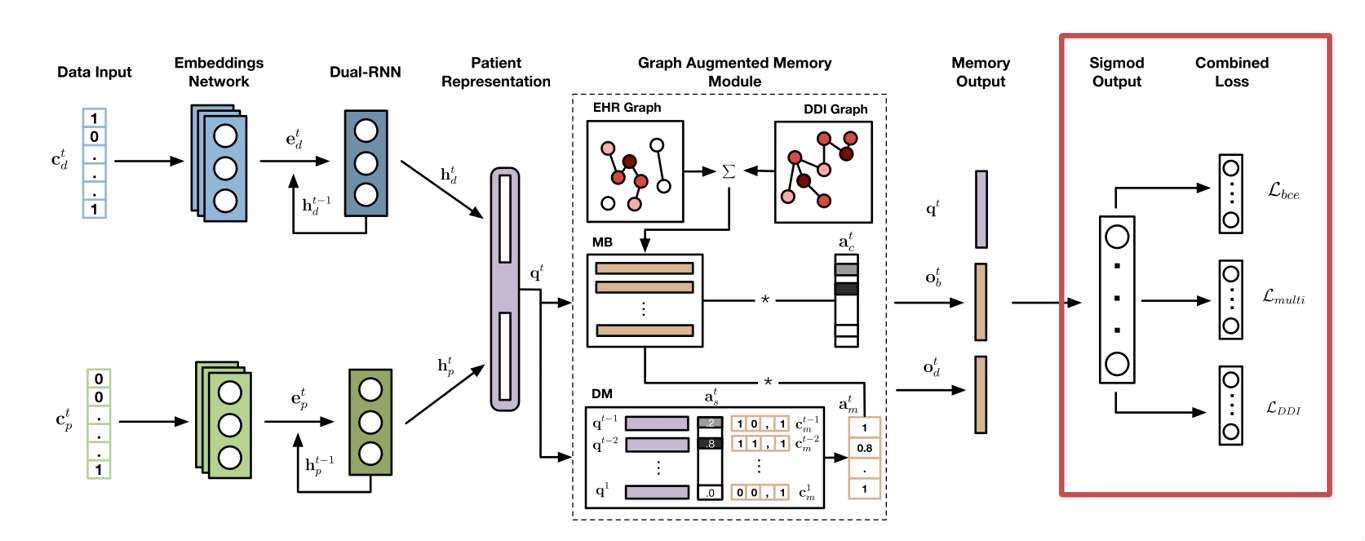

The GAMENet authors combined multiple loss functions together to balance safety and accuracy.

* Accuracy: The authors combine binary cross entropy loss and multi-label margin loss

$$\mathcal{L}_p = \pi[0]\mathcal{L}_{bce}+\pi[1]\mathcal{L}_{multi}$$

* Safety: The authors used DDI loss, which is large when there is a large pair-wise DDI probability

$$\mathcal{L}_{DDI} = \sum_t^T\sum_{i,j}(A_d\odot(\hat{y}_t^\mathsf{T}\hat{y}_t))[i,j]$$

They then combine the two, using the following function:

$$
\mathcal{L} =
    \begin{cases}
        \mathcal{L}_p & \text{if } s' \le s \\
        \mathcal{L}_{DDI}, \text{with prob. } p = \exp(-\frac{s' - s}{Temp}) & \text{if } s' \gt s \\
        \mathcal{L}_p, \text{with prob. } p = 1 - \exp(-\frac{s' - s}{Temp}) & \text{if } s' \gt s
    \end{cases}
$$

where $s$ is the target DDI rate, and $s'$ is the current DDI rate

In [ ]:
def compute_combined_loss(predictions, loss_ddi, loss_bce_target, loss_multi_target, config):
    used_ddi_loss = False
    loss_bce = F.binary_cross_entropy_with_logits(
        predictions,
        torch.FloatTensor(loss_bce_target).to(config['device']))
    loss_multi = F.multilabel_margin_loss(
        F.sigmoid(predictions),
        torch.LongTensor(loss_multi_target).to(config['device']))
    
    if config['use_ddi']:
        predictions = F.sigmoid(predictions).detach().cpu().numpy()[0]
        predictions[predictions >= 0.5] = 1
        y_label = np.where(predictions == 1)[0]
        
        current_ddi_rate = ddi_rate_score([[y_label]], path='./data/ddi_A_final.pkl')
        
        p = np.exp((config['target_ddi'] - current_ddi_rate)/config['temp'])
        p = np.random.rand() >= p
        
        if current_ddi_rate <= config['target_ddi'] or p:
            loss = config['pi'][0] * loss_bce + config['pi'][1] * loss_multi
        else:
            loss = loss_ddi
            used_ddi_loss = True
                
    else: # Don't use DDI graph
        loss = config['pi'][0] * loss_bce + config['pi'][1] * loss_multi
    
    return loss, used_ddi_loss

# 3. Training and Evaluation

## 3.1. Evaluation

In [ ]:
def eval(model, data_eval, config, epoch):
    # evaluate
    print('')
    model.eval()
    smm_record = []
    ja, prauc, avg_p, avg_r, avg_f1 = [[] for _ in range(5)]
    case_study = defaultdict(dict)
    med_cnt = 0
    visit_cnt = 0
    for step, input in enumerate(data_eval):
        y_gt = []
        y_pred = []
        y_pred_prob = []
        y_pred_label = []
        for adm_idx, adm in enumerate(input):

            target_output1 = model(input[:adm_idx+1])

            y_gt_tmp = np.zeros(config['vocab_size'][2])
            y_gt_tmp[adm[2]] = 1
            y_gt.append(y_gt_tmp)

            target_output1 = F.sigmoid(target_output1).detach().cpu().numpy()[0]
            y_pred_prob.append(target_output1)
            y_pred_tmp = target_output1.copy()
            y_pred_tmp[y_pred_tmp>=0.5] = 1
            y_pred_tmp[y_pred_tmp<0.5] = 0
            y_pred.append(y_pred_tmp)
            y_pred_label_tmp = np.where(y_pred_tmp == 1)[0]
            y_pred_label.append(sorted(y_pred_label_tmp))
            visit_cnt += 1
            med_cnt += len(y_pred_label_tmp)


        smm_record.append(y_pred_label)
        adm_ja, adm_prauc, adm_avg_p, adm_avg_r, adm_avg_f1 = multi_label_metric(np.array(y_gt), np.array(y_pred), np.array(y_pred_prob))
        case_study[adm_ja] = {'ja': adm_ja, 'patient': input, 'y_label': y_pred_label}

        ja.append(adm_ja)
        prauc.append(adm_prauc)
        avg_p.append(adm_avg_p)
        avg_r.append(adm_avg_r)
        avg_f1.append(adm_avg_f1)
        llprint('\rEval--Epoch: %d, Step: %d/%d' % (epoch, step, len(data_eval)))

    # ddi rate
    ddi_rate = ddi_rate_score(smm_record,path='./data/ddi_A_final.pkl')

    llprint('\tDDI Rate: %.4f, Jaccard: %.4f,  PRAUC: %.4f, AVG_PRC: %.4f, AVG_RECALL: %.4f, AVG_F1: %.4f\n' % (
        ddi_rate, np.mean(ja), np.mean(prauc), np.mean(avg_p), np.mean(avg_r), np.mean(avg_f1)
    ))
    dill.dump(obj=smm_record, file=open('./data/gamenet_records.pkl', 'wb'))
    dill.dump(case_study, open(os.path.join('saved', config['model_name'], 'case_study.pkl'), 'wb'))

    # print('avg med', med_cnt / visit_cnt)

    return ddi_rate, np.mean(ja), np.mean(prauc), np.mean(avg_p), np.mean(avg_r), np.mean(avg_f1)

#eval(model, data_test, voc_size, 0)

In [ ]:
def load_and_eval(model, config, epoch, data_test, results):
    directory = f'./saved/{config["model_name"]}'
    regex = fr'^Epoch_{epoch}_'
    filepath = ""

    pattern = re.compile(regex)
    for root, dirs, files in os.walk(directory):
        for file in files:
            if pattern.match(file):
                filepath = os.path.join(root, file)
    
    if filepath != "":
        print(f'loading {filepath}')
        model.load_state_dict(torch.load(filepath))
        result = eval(model, data_test, config, epoch)
        results.append({
            'config': config,
            'best_epoch': best_epoch,
            'ddi': result[0],
            'ja': result[1],
            'prauc': result[2],
            'avg_p': result[3],
            'avg_r': result[4],
            'avg_f1': result[5]
        })
    else:
        print('Unable to find that model')

## 3.2. Train

In [ ]:
def train(model, data_train, config):
  if not os.path.exists(os.path.join("saved", config['model_name'])):
    os.makedirs(os.path.join("saved", config['model_name']))

  best_epoch = 0
  best_ja = 0
  start_time = time.time()

  for epoch in range(config['epochs']):
    loss_record = []
    epoch_time = time.time()
    model.train()
    prediction_loss_cnt = 0
    ddi_loss_cnt = 0

    for step, input in enumerate(data_train):
      for idx, adm in enumerate(input):
        seq_input = input[:idx+1]
        loss_bce_target = np.zeros((1, config['vocab_size'][2]))
        loss_bce_target[:, adm[2]] = 1
        loss_multi_target = np.full((1, config['vocab_size'][2]), -1)
        
        for idx, item in enumerate(adm[2]):
          loss_multi_target[0][idx] = item

        predictions, loss_ddi = model(seq_input)
        loss, inc_ddi_loss_cnt = compute_combined_loss(predictions, loss_ddi, loss_bce_target, loss_multi_target, config)

        if inc_ddi_loss_cnt:
            ddi_loss_cnt += 1
        else:
            prediction_loss_cnt += 1

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        loss_record.append(loss.item())

      llprint('\rTrain--Epoch: %d, Step: %d/%d, L_p cnt: %d, L_neg cnt: %d' % 
              (epoch, step, len(data_train), prediction_loss_cnt, ddi_loss_cnt))
      
    # annealing
    config['temp'] *= config['decay_weight']

    ddi_rate, ja, prauc, avg_p, avg_r, avg_f1 = eval(model, data_eval, config, epoch)

    end_time = time.time()
    elapsed_time = (end_time - epoch_time) / 60
    llprint('\tEpoch: %d, Loss: %.4f, One Epoch Time: %.2fm, Appro Left Time: %.2fh\n' % 
            (epoch, np.mean(loss_record), elapsed_time, elapsed_time * ( config['epochs'] - epoch - 1)/60))

    torch.save(
        model.state_dict(),
        open(os.path.join(
            'saved',
            config['model_name'],
            'Epoch_%d_JA_%.4f_DDI_%.4f.model' % (epoch, ja, ddi_rate)),
            'wb'))
    
    print('')
    if epoch != 0 and best_ja < ja:
      best_epoch = epoch
      best_ja = ja

  total_time = (time.time() - start_time) / 60 / 60 
  print('best_epoch:', best_epoch)
  print(f'total time: {total_time}h')
  return best_epoch

# Run Experiments

In [ ]:
results = []

## Hyperparameters from paper authors' code

In [ ]:
config = {
    'model_name': 'GAMENet',
    'device': torch.device('cpu:0'),
    'epochs': 40,
    'use_ddi': True,
    'use_dm': True,
    'vocab_size': (len(diag_voc.idx2word), len(pro_voc.idx2word), len(med_voc.idx2word)),
    'embedding_dim': 64,
    'temp': 0.5,
    'decay_weight': 0.85,
    'target_ddi': 0.05,
    'pi': [.9, .01],
    'learning_rate': 0.0002
}

model = GAMENet(
    config['vocab_size'],
    ehr_adj,
    ddi_adj,
    config['embedding_dim'],
    config['device'],
    config['use_ddi'],
    config['use_dm']
)
model.to(device=config['device'])

print('GAMENet Model parameters:', get_n_params(model))
optimizer = Adam(list(model.parameters()), lr=config['learning_rate'])

best_epoch = train(model, data_train, config)

GAMENet Model parameters: 452434
Train--Epoch: 0, Step: 4232/4233, L_p cnt: 4813, L_neg cnt: 5662
Eval--Epoch: 0, Step: 1058/1059	DDI Rate: 0.0904, Jaccard: 0.3580,  PRAUC: 0.6221, AVG_PRC: 0.6266, AVG_RECALL: 0.4709, AVG_F1: 0.5190
	Epoch: 0, Loss: 0.1204, One Epoch Time: 1.87m, Appro Left Time: 1.22h

Train--Epoch: 1, Step: 4232/4233, L_p cnt: 6047, L_neg cnt: 4428
Eval--Epoch: 1, Step: 1058/1059	DDI Rate: 0.0891, Jaccard: 0.3599,  PRAUC: 0.6243, AVG_PRC: 0.6344, AVG_RECALL: 0.4688, AVG_F1: 0.5210
	Epoch: 1, Loss: 0.1434, One Epoch Time: 1.94m, Appro Left Time: 1.23h

Train--Epoch: 2, Step: 4232/4233, L_p cnt: 5524, L_neg cnt: 4951
Eval--Epoch: 2, Step: 1058/1059	DDI Rate: 0.0398, Jaccard: 0.3726,  PRAUC: 0.6380, AVG_PRC: 0.6538, AVG_RECALL: 0.4763, AVG_F1: 0.5341
	Epoch: 2, Loss: 0.1284, One Epoch Time: 1.93m, Appro Left Time: 1.19h

Train--Epoch: 3, Step: 4232/4233, L_p cnt: 6795, L_neg cnt: 3680
Eval--Epoch: 3, Step: 1058/1059	DDI Rate: 0.0572, Jaccard: 0.3928,  PRAUC: 0.6524, AVG

In [ ]:
load_and_eval(model, config, best_epoch, data_test, results)

loading ./saved/GAMENet/Epoch_39_JA_0.4557_DDI_0.0872.model

Eval--Epoch: 39, Step: 1057/1058	DDI Rate: 0.0852, Jaccard: 0.4501,  PRAUC: 0.6885, AVG_PRC: 0.6231, AVG_RECALL: 0.6277, AVG_F1: 0.6072


## Tweaked hyperparameters

In [ ]:
config = {
    'model_name': 'GAMENet_.95_decay_weight',
    'device': torch.device('cpu:0'),
    'epochs': 40,
    'use_ddi': True,
    'use_dm': True,
    'vocab_size': (len(diag_voc.idx2word), len(pro_voc.idx2word), len(med_voc.idx2word)),
    'embedding_dim': 64,
    'temp': 0.5,
    'decay_weight': 0.95,
    'target_ddi': 0.05,
    'pi': [.9, .01],
    'learning_rate': 0.0002
}

model = GAMENet(
    config['vocab_size'],
    ehr_adj,
    ddi_adj,
    config['embedding_dim'],
    config['device'],
    config['use_ddi'],
    config['use_dm']
)
model.to(device=config['device'])

print('GAMENet Model parameters:', get_n_params(model))
optimizer = Adam(list(model.parameters()), lr=config['learning_rate'])

best_epoch = train(model, data_train, config)

GAMENet Model parameters: 452434
Train--Epoch: 0, Step: 4232/4233, L_p cnt: 5206, L_neg cnt: 5269
Eval--Epoch: 0, Step: 1058/1059	DDI Rate: 0.0909, Jaccard: 0.3627,  PRAUC: 0.6195, AVG_PRC: 0.6152, AVG_RECALL: 0.4860, AVG_F1: 0.5242
	Epoch: 0, Loss: 0.1302, One Epoch Time: 2.03m, Appro Left Time: 1.32h

Train--Epoch: 1, Step: 4232/4233, L_p cnt: 6350, L_neg cnt: 4125
Eval--Epoch: 1, Step: 1058/1059	DDI Rate: 0.0293, Jaccard: 0.3598,  PRAUC: 0.6314, AVG_PRC: 0.6478, AVG_RECALL: 0.4638, AVG_F1: 0.5207
	Epoch: 1, Loss: 0.1511, One Epoch Time: 2.04m, Appro Left Time: 1.29h

Train--Epoch: 2, Step: 4232/4233, L_p cnt: 6429, L_neg cnt: 4046
Eval--Epoch: 2, Step: 1058/1059	DDI Rate: 0.0575, Jaccard: 0.3780,  PRAUC: 0.6415, AVG_PRC: 0.6437, AVG_RECALL: 0.4921, AVG_F1: 0.5392
	Epoch: 2, Loss: 0.1525, One Epoch Time: 1.97m, Appro Left Time: 1.21h

Train--Epoch: 3, Step: 4232/4233, L_p cnt: 5942, L_neg cnt: 4533
Eval--Epoch: 3, Step: 1058/1059	DDI Rate: 0.0629, Jaccard: 0.3951,  PRAUC: 0.6490, AVG

In [ ]:
load_and_eval(model, config, best_epoch, data_test, results)

In [ ]:
config = {
    'model_name': 'GAMENet_no_decay',
    'device': torch.device('cpu:0'),
    'epochs': 40,
    'use_ddi': True,
    'use_dm': True,
    'vocab_size': (len(diag_voc.idx2word), len(pro_voc.idx2word), len(med_voc.idx2word)),
    'embedding_dim': 64,
    'temp': 0.5,
    'decay_weight': 1,
    'target_ddi': 0.05,
    'pi': [.9, .01],
    'learning_rate': 0.0002
}

model = GAMENet(
    config['vocab_size'],
    ehr_adj,
    ddi_adj,
    config['embedding_dim'],
    config['device'],
    config['use_ddi'],
    config['use_dm']
)
model.to(device=config['device'])

print('GAMENet Model parameters:', get_n_params(model))
optimizer = Adam(list(model.parameters()), lr=config['learning_rate'])

best_epoch = train(model, data_train, config)

In [ ]:
load_and_eval(model, config, best_epoch, data_test, results)

## Ablations

### Remove DM

In [ ]:
config = {
    'model_name': 'GAMENet_without_DM',
    'device': torch.device('cpu:0'),
    'epochs': 40,
    'use_ddi': True,
    'use_dm': False,
    'vocab_size': (len(diag_voc.idx2word), len(pro_voc.idx2word), len(med_voc.idx2word)),
    'embedding_dim': 64,
    'temp': 0.5,
    'decay_weight': 0.85,
    'target_ddi': 0.05,
    'pi': [.9, .01],
    'learning_rate': 0.0002
}

model = GAMENet(
    config['vocab_size'],
    ehr_adj,
    ddi_adj,
    config['embedding_dim'],
    config['device'],
    config['use_ddi'],
    config['use_dm']
)
model.to(device=config['device'])

print('GAMENet Model parameters:', get_n_params(model))
optimizer = Adam(list(model.parameters()), lr=config['learning_rate'])

best_epoch = train(model, data_train, config)

In [ ]:
load_and_eval(model, config, best_epoch, data_test, results)

### Remove DDI (from paper)

In [ ]:
config = {
    'model_name': 'GAMENet_no_DDI',
    'device': torch.device('cpu:0'),
    'epochs': 40,
    'use_ddi': False,
    'use_dm': True,
    'vocab_size': (len(diag_voc.idx2word), len(pro_voc.idx2word), len(med_voc.idx2word)),
    'embedding_dim': 64,
    'temp': 0.5,
    'decay_weight': 0.85,
    'target_ddi': 0.05,
    'pi': [.9, .01],
    'learning_rate': 0.0002
}

model = GAMENet(
    config['vocab_size'],
    ehr_adj,
    ddi_adj,
    config['embedding_dim'],
    config['device'],
    config['use_ddi'],
    config['use_dm']
)
model.to(device=config['device'])

print('GAMENet Model parameters:', get_n_params(model))
optimizer = Adam(list(model.parameters()), lr=config['learning_rate'])

best_epoch = train(model, data_train, config)

In [ ]:
load_and_eval(model, config, best_epoch, data_test, results)

# Results

In [ ]:
def print_results_table(results):
  headers = ['model_name'] + list(results[0].keys())[1:]
  row_format = "{:<12}" * len(headers)
  
  print(row_format.format(*headers))
  for result in results:
      model_name = result['config']['model_name']
      other_values = list(result.values())[1:]
      print(row_format.format(model_name, *other_values))

In [ ]:
print_results_table(results)

# References

A. Johnson, T. Pollard, and R. Mark. 2016. Mimic-iii clinical database (version 1.4). PhysioNet.

Junyuan Shang, Cao Xiao, Tengfei Ma, Hongyan Li, and Jimeng Sun. 2019. Gamenet: Graph augmented memory networks for recommending medication combination. Proceedings of the AAAI Conference on Artificial Intelligence, 33(01):1126–1133.

N. Tatonetti, P. Ye, R. Daneshjou, and R Altman. 2012. Data-driven prediction of drug effects and interactions. Science Translational Medicine, 4(125)

Weston, J.; Chopra, S.; and Bordes, A. 2015. Memory networks. In International Conference on Learning Representations.